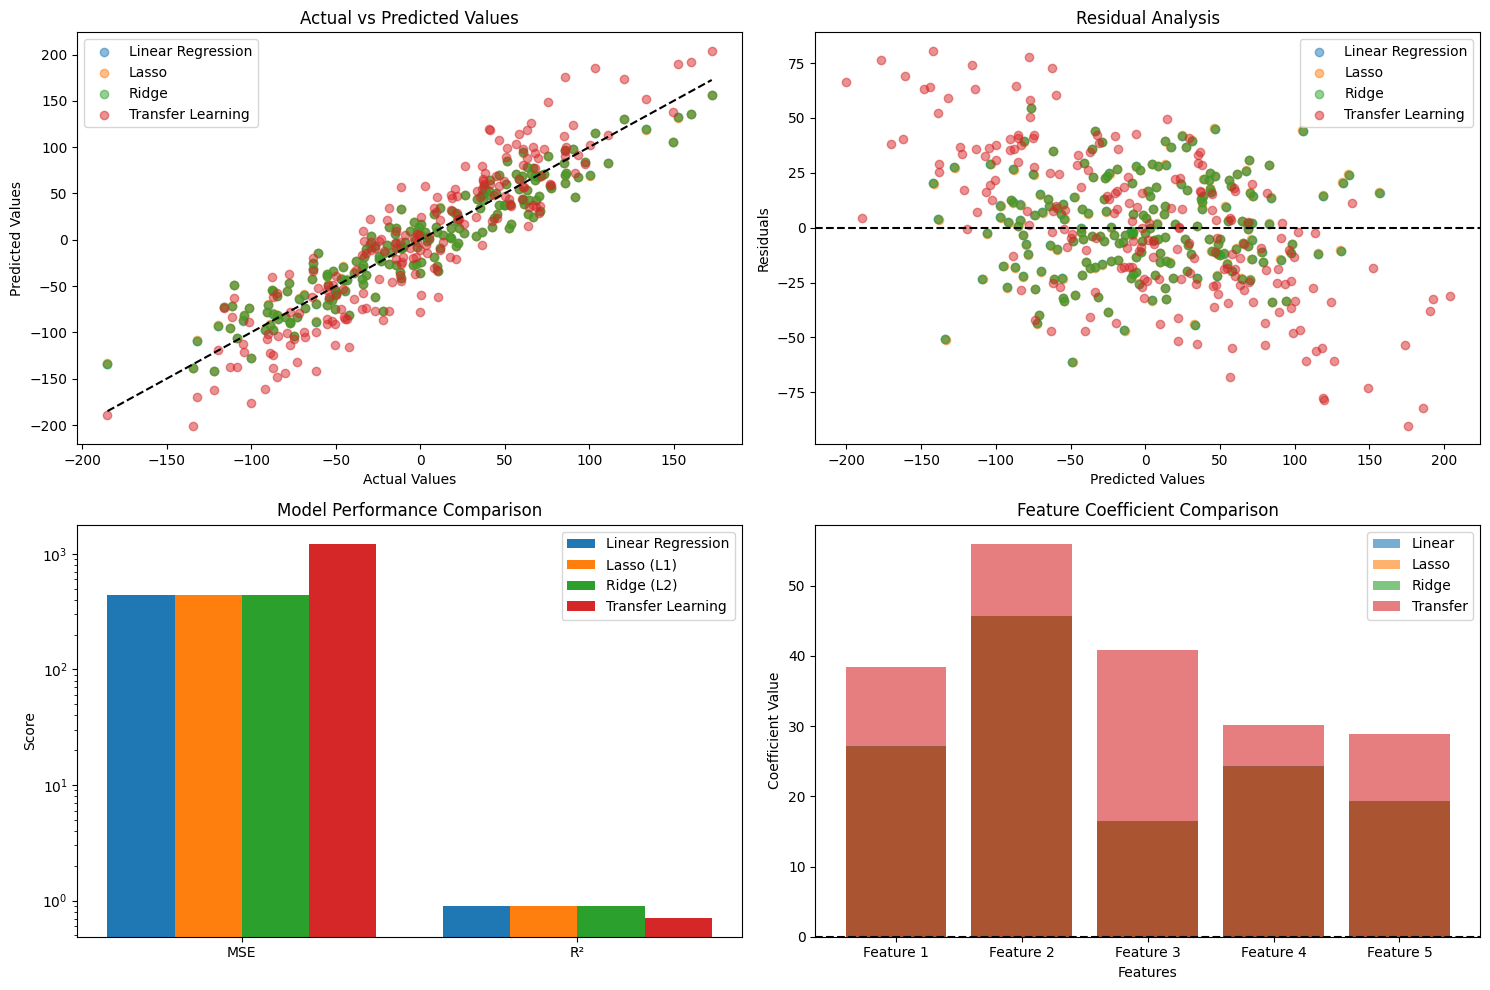

Model Performance Metrics:

Linear Regression:
  MSE: 443.62
  R²: 0.89

Lasso (L1):
  MSE: 444.35
  R²: 0.89

Ridge (L2):
  MSE: 443.65
  R²: 0.89

Transfer Learning:
  MSE: 1225.55
  R²: 0.71


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# =============================================
# 1. Synthetic Data Generation
# =============================================
np.random.seed(42)

# Base dataset (target task)
X, y = make_regression(n_samples=1000, n_features=5, noise=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Source dataset for transfer learning (related but different distribution)
X_source, y_source = make_regression(n_samples=500, n_features=5, noise=15, random_state=24)

# =============================================
# 2. Model Training
# =============================================
# Vanilla Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# L1 Regularization (Lasso)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# L2 Regularization (Ridge)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

# Transfer Learning Approach:
# 1. Pretrain on source data
# 2. Fine-tune on target data
transfer_model = LinearRegression()
transfer_model.fit(X_source, y_source)  # Pretraining on source data

# Fine-tuning on target data (warm start not available for OLS, so we refit)
transfer_model.fit(np.vstack([X_source, X_train]), np.concatenate([y_source, y_train]))

# =============================================
# 3. Model Evaluation
# =============================================
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }

results = {
    'Linear Regression': evaluate_model(lr, X_test, y_test),
    'Lasso (L1)': evaluate_model(lasso, X_test, y_test),
    'Ridge (L2)': evaluate_model(ridge, X_test, y_test),
    'Transfer Learning': evaluate_model(transfer_model, X_test, y_test)
}

# =============================================
# 4. Visualizations
# =============================================
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted Values
plt.subplot(2, 2, 1)
for name, model in [('Linear Regression', lr), 
                    ('Lasso', lasso), 
                    ('Ridge', ridge), 
                    ('Transfer Learning', transfer_model)]:
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()

# Plot 2: Residual Analysis
plt.subplot(2, 2, 2)
for name, model in [('Linear Regression', lr), 
                    ('Lasso', lasso), 
                    ('Ridge', ridge), 
                    ('Transfer Learning', transfer_model)]:
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, label=name)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.legend()

# Plot 3: Model Performance Comparison
plt.subplot(2, 2, 3)
metrics = ['MSE', 'R²']
x = np.arange(len(metrics))
width = 0.2

for i, (model_name, scores) in enumerate(results.items()):
    plt.bar(x + i*width, [scores['MSE'], scores['R²']], width, label=model_name)

plt.xticks(x + width*1.5, metrics)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.yscale('log')  # Log scale for MSE visualization
plt.legend()

# Plot 4: Coefficient Comparison
plt.subplot(2, 2, 4)
models = [lr, lasso, ridge, transfer_model]
names = ['Linear', 'Lasso', 'Ridge', 'Transfer']
features = [f'Feature {i+1}' for i in range(X.shape[1])]

for model, name in zip(models, names):
    plt.bar(features, model.coef_, alpha=0.6, label=name)

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficient Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# =============================================
# 5. Print Results
# =============================================
print("Model Performance Metrics:")
for model, scores in results.items():
    print(f"\n{model}:")
    print(f"  MSE: {scores['MSE']:.2f}")
    print(f"  R²: {scores['R²']:.2f}")